In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# ETL and Target Creation


In [3]:
"""

labeling and load data

"""
import pandas as pd
from modeling_funcs import ETL
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


labeling_parameters = {
  'target_symbol' : 'EURUSD',
  'trade_mode': 'long' ,   #"long" , "short"
  'trg_look_ahead' : 300,
  'trg_take_profit' : 40,
  'trg_stop_loss' : 15,
  'n_rand_features':3,
}
##? name of the target column
target_col = f"trg_clf_{labeling_parameters['trade_mode']}_{labeling_parameters['target_symbol']}_M{labeling_parameters['trg_look_ahead']}_TP{labeling_parameters['trg_take_profit']}_SL{labeling_parameters['trg_stop_loss']}"
dataset_path="..\pipeline\data\dataset\dataset.parquet"
stage_one_data_path = "..\pipeline\data\stage_one_data\EURUSD_stage_one.parquet"


df_all = ETL(
  path = dataset_path,
  stage_one_data_path = stage_one_data_path,
  trade_mode = labeling_parameters["trade_mode"],
  target_symbol = labeling_parameters["target_symbol"],
  trg_look_ahead = labeling_parameters["trg_look_ahead"],
  trg_take_profit = labeling_parameters["trg_take_profit"],
  trg_stop_loss = labeling_parameters["trg_stop_loss"],
  n_rand_features = labeling_parameters["n_rand_features"],
  target_col=target_col,
  base_time_frame=5,
)

<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:23: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:23: SyntaxWarning: invalid escape sequence '\p'
C:\Users\MT\AppData\Local\Temp\ipykernel_11176\327531521.py:22: SyntaxWarning: invalid escape sequence '\p'
  dataset_path="..\pipeline\data\dataset\dataset.parquet"
C:\Users\MT\AppData\Local\Temp\ipykernel_11176\327531521.py:23: SyntaxWarning: invalid escape sequence '\p'
  stage_one_data_path = "..\pipeline\data\stage_one_data\EURUSD_stage_one.parquet"


Len all columns in dataframe is 253
Len read columns is 253
Calculating target --->
---> Target trg_clf_long_EURUSD_M480_TP40_SL15 has been generated in 3.87 seconds
df shape:  (129047, 254)
--> df final shape: (129047, 256)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-09-27 05:45:00
--> number of unique days: 129047


Percentage of the True Class: 7.2


<Axes: xlabel='target', ylabel='count'>

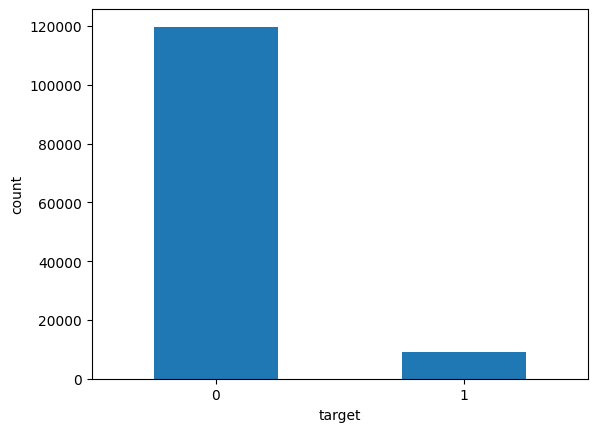

In [4]:
print(f"Percentage of the True Class: {df_all[df_all.target == 1].shape[0]/ df_all.shape[0]*100:.1f}")
df_all["target"].value_counts().sort_index().plot(
    kind="bar", rot=0, ylabel="count"
)

# Run Cross Validation

In [6]:
"""
Create Time-Series Cross Validation Folds

"""
from quant_cross_validation import split_time_series

data_parameters = {
  'n_splits' : 5,
  'max_train_size' : 200*288,
  'test_size' : 30*288,
  'train_test_gap':10*288,
}


folds = split_time_series(
    df_all,
    max_train_size=data_parameters['max_train_size'],
    n_splits=data_parameters['n_splits'],
    test_size=data_parameters['test_size'],
    train_test_gap=data_parameters['train_test_gap'],
)

In [42]:
folds

{0: {'train_dates': DatetimeIndex(['2023-01-10 03:55:00', '2023-01-10 04:00:00',
                 '2023-01-10 04:05:00', '2023-01-10 04:10:00',
                 '2023-01-10 04:15:00', '2023-01-10 04:20:00',
                 '2023-01-10 04:25:00', '2023-01-10 04:30:00',
                 '2023-01-10 04:35:00', '2023-01-10 04:40:00',
                 ...
                 '2023-07-21 05:00:00', '2023-07-21 05:05:00',
                 '2023-07-21 05:10:00', '2023-07-21 05:15:00',
                 '2023-07-21 05:20:00', '2023-07-21 05:25:00',
                 '2023-07-21 05:30:00', '2023-07-21 05:35:00',
                 '2023-07-21 05:40:00', '2023-07-21 05:45:00'],
                dtype='datetime64[ns]', name='_time', length=39767, freq=None),
  'valid_dates': DatetimeIndex(['2023-08-04 05:50:00', '2023-08-04 05:55:00',
                 '2023-08-04 06:00:00', '2023-08-04 06:05:00',
                 '2023-08-04 06:10:00', '2023-08-04 06:15:00',
                 '2023-08-04 06:20:00', '2023-

In [40]:
"""
Model creation

"""

##? for random forest
mdoel_parameters = {
  'n_estimators' : 200,
  'max_depth': 4,
  'max_features' : 0.5,
  'max_samples' : 0.5,
  'class_weight': {0:1,1:1}, # 'balanced'
  'random_state': 42,
  'n_jobs': -1
}

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**mdoel_parameters)

In [41]:

from quant_cross_validation import quant_CV

non_feature_columns = [
  "target", "pred_as_val", "pred_val_proba", "pred_as_test", "pred_test_proba", "K","symbol",
  ]

input_cols_and_type, input_cols, evals, val_predictions, test_predictions, importance_df = quant_CV(
  df=df_all,
  folds=folds,
  model=clf,
  non_feature_columns = non_feature_columns,
  )

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Fold 0:
--> fold train size: (39767, 261)
--> fold valid size: (8640, 261)
--> fold test size: (8640, 261)
  dataset  K  f1_score  precision  recall   TP  FP     TN    FN  \
0   train  0      0.07       0.99    0.04  147   1  35891  3728   
1   valid  0      0.00       0.00    0.00    0  79   8102   459   
2    test  0      0.00       0.00    0.00    0   0   8083   557   

             Min_date            Max_date train_duration  n_unique_days  \
0 2023-01-10 03:55:00 2023-07-21 05:45:00           37.5             -1   
1 2023-08-04 05:50:00 2023-09-15 05:45:00           37.5              4   
2 2023-09-15 05:50:00 2023-10-27 05:45:00           37.5              0   

  n_max_daily_sig  
0            None  
1              30  
2             NaN  
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Fold 1:
--> fold train size: (57047, 261)
--> fold valid size: (8640, 261)
--> fold test size: (8640,

# Feature Importance

In [43]:
importance_df

,feature_name,importance_fold_0,importance_fold_1,importance_fold_2,importance_fold_3,importance_fold_4,mean_importance,median_importance,std_importance,cv
135,fe_market_close_EURUSD_Sydney_time,0.115251,0.121006,0.181395,0.124374,0.085322,0.125470,0.121006,0.034875,0.277952
13,fe_time_hour,0.076821,0.070165,0.164413,0.107831,0.117707,0.107387,0.107831,0.037678,0.350857
137,fe_market_close_EURUSD_London_time,0.038599,0.060508,0.058378,0.058020,0.067045,0.056510,0.058378,0.010649,0.188437
6,fe_time_day_of_year,0.062521,0.104784,0.014848,0.033925,0.050624,0.053340,0.050624,0.033900,0.635537
5,fe_time_day_of_month,0.040148,0.007372,0.005317,0.034221,0.140416,0.045495,0.034221,0.055302,1.215571
...,...,...,...,...,...,...,...,...,...,...
196,fe_cndl_shift_EURUSD_M1440_HIGH_to_CLOSE_-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
195,fe_cndl_shift_EURUSD_M1440_HIGH_to_LOW_-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
194,fe_cndl_shift_EURUSD_M1440_CLOSE_to_OPEN_-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
193,fe_cndl_shift_EURUSD_M240_CLOSE_to_LOW_-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


In [32]:
importance_df.sort_values("mean_importance", ascending=False, inplace= True)
importance_df.reset_index(inplace=True,drop=True)
importance_df[importance_df.feature_name.str.startswith('RANDOM')]

,level_0,index,feature_name,importance_fold_0,importance_fold_1,importance_fold_2,importance_fold_3,importance_fold_4,mean_importance,median_importance,std_importance,cv
123,121,251,RANDOM_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
126,124,252,RANDOM_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
253,253,253,RANDOM_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [33]:
import matplotlib.pyplot as plt

def plot_feature_importance(importance_df,top_count=20):
    plt.figure(figsize=(10,6))
    importances_df = importance_df.sort_values(
        "mean_importance", ascending=False
    )
    plt.barh(
        importances_df.feature_name.iloc[:top_count],
        importances_df.mean_importance.iloc[:top_count],
    )
    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance")

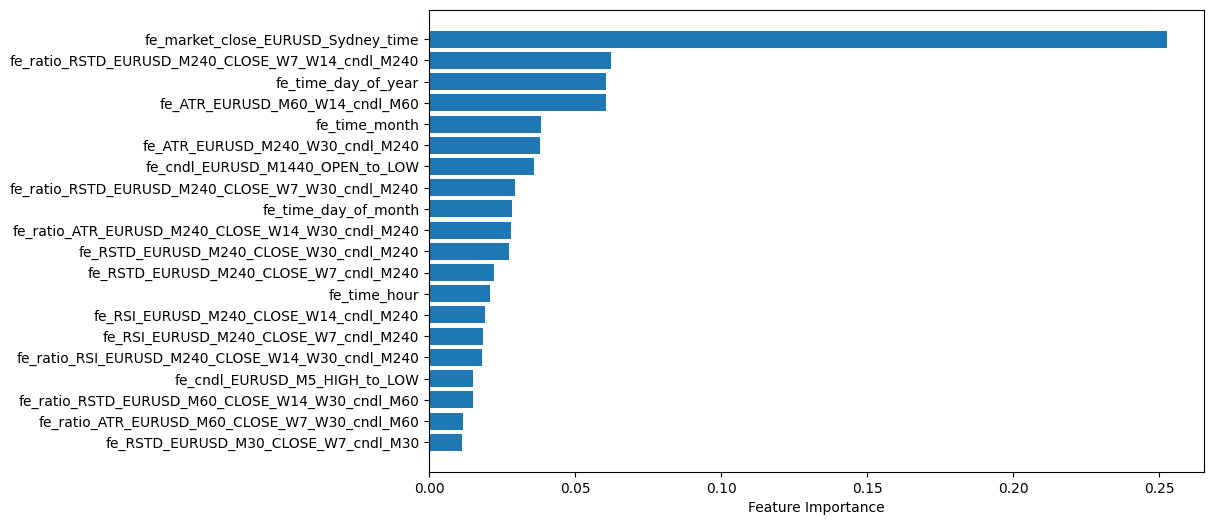

In [34]:
plot_feature_importance(importance_df,top_count=20)

In [35]:
importances_df = importance_df.sort_values(
  "mean_importance", ascending=False
)
top_count = 30
selected_features = set(importances_df.iloc[:top_count].feature_name)
selected_features

{'fe_ATR_EURUSD_M240_W30_cndl_M240',
 'fe_ATR_EURUSD_M60_W14_cndl_M60',
 'fe_RSI_EURUSD_M240_CLOSE_W14_cndl_M240',
 'fe_RSI_EURUSD_M240_CLOSE_W7_cndl_M240',
 'fe_RSTD_EURUSD_M15_CLOSE_W14_cndl_M15',
 'fe_RSTD_EURUSD_M240_CLOSE_W30_cndl_M240',
 'fe_RSTD_EURUSD_M240_CLOSE_W7_cndl_M240',
 'fe_RSTD_EURUSD_M30_CLOSE_W7_cndl_M30',
 'fe_RSTD_EURUSD_M5_CLOSE_W30_cndl_M5',
 'fe_WIN_argmin_EURUSD_W480_M5',
 'fe_cndl_EURUSD_M1440_CLOSE_to_LOW',
 'fe_cndl_EURUSD_M1440_OPEN_to_LOW',
 'fe_cndl_EURUSD_M5_HIGH_to_LOW',
 'fe_market_close_EURUSD_London',
 'fe_market_close_EURUSD_London_time',
 'fe_market_close_EURUSD_Sydney_time',
 'fe_market_close_EURUSD_Tokyo',
 'fe_ratio_ATR_EURUSD_M240_CLOSE_W14_W30_cndl_M240',
 'fe_ratio_ATR_EURUSD_M60_CLOSE_W7_W14_cndl_M60',
 'fe_ratio_ATR_EURUSD_M60_CLOSE_W7_W30_cndl_M60',
 'fe_ratio_RSI_EURUSD_M240_CLOSE_W14_W30_cndl_M240',
 'fe_ratio_RSI_EURUSD_M240_CLOSE_W7_W14_cndl_M240',
 'fe_ratio_RSI_EURUSD_M240_CLOSE_W7_W30_cndl_M240',
 'fe_ratio_RSTD_EURUSD_M240_CLOSE_W7

# KNN Model

In [38]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=15)

In [39]:
input_cols_and_type, input_cols, evals, val_predictions, test_predictions, importance_df = quant_CV(
  df=df_all,
  folds=folds,
  model=knn,
  non_feature_columns = non_feature_columns,
  )

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Fold 0:
--> fold train size: (39767, 261)
--> fold valid size: (8640, 261)
--> fold test size: (8640, 261)
  dataset  K  f1_score  precision  recall    TP   FP     TN   FN  \
0   train  0      0.84       0.93    0.76  2954  233  35659  921   
1   valid  0      0.12       0.12    0.12    54  384   7797  405   
2    test  0      0.06       0.06    0.06    31  504   7579  526   

             Min_date            Max_date train_duration  n_unique_days  \
0 2023-01-10 03:55:00 2023-07-21 05:45:00            1.6             -1   
1 2023-08-04 05:50:00 2023-09-15 05:45:00            1.6             26   
2 2023-09-15 05:50:00 2023-10-27 05:45:00            1.6             27   

  n_max_daily_sig  
0            None  
1              57  
2              71  
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Fold 1:
--> fold train size: (57047, 261)
--> fold valid size: (8640, 261)
--> fold test size: (8